In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Deep Learning necessities
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, LSTM, Bidirectional, Dropout, Conv1D, MaxPool1D
from keras.layers import GlobalMaxPool1D, GRU
from keras import optimizers

import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['Sarcasm_Headlines_Dataset.json']


<a id='contents'></a>
## Contents:

### 1. [Understand folder structure, view a few data points](#1.1)
### 2. [Prepare Data for modelling](#2.1)
### 3. [Build and train Fully Connected Model](#3.1)
### 4. [Build and train LSTM model ](#4)
### 5. [Build and train Conv1D model](#5)
### 6. [Build and train Conv1D + GRU model](#6)

In [2]:
# Util functions
def prep_data(text, tok):
    seq = tok.texts_to_sequences([text])
    data = pad_sequences(seq, MAX_SEQ_LENGTH)
    return data

def plot(history):
    hist = history.history
    train_loss, train_acc = hist['loss'], hist['acc']
    val_loss, val_acc = hist['val_loss'], hist['val_acc']
    epochs = range(1, len(train_acc)+1)
    
    plt.plot(epochs, train_acc, 'g', label='Training acc')
    plt.plot(epochs, val_acc, 'o', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, train_loss, 'g', label='Training loss')
    plt.plot(epochs, val_loss, 'o', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

<a id='1.1'></a>
# 1. Understand folder structure, view a few data points 

In [3]:
df = pd.read_json('../input/Sarcasm_Headlines_Dataset.json', lines=True)
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


<a id='2.1'></a>
# 2. Prepare Data for Modelling

In [4]:
df = df[['headline', 'is_sarcastic']]

In [5]:
MAX_WORDS = 20000

In [6]:
tok = Tokenizer(num_words = MAX_WORDS) # keeping 10000 now for first iteration
tok.fit_on_texts(df.headline)
seqs = tok.texts_to_sequences(df.headline)

In [7]:
# Find length of sentence 
df['length'] = df['headline'].apply(lambda x: len(x.split(' ')))

In [8]:
# Dataset seems balanced
df.is_sarcastic.value_counts()

0    14985
1    11724
Name: is_sarcastic, dtype: int64

In [9]:
MAX_SEQ_LENGTH = 40

In [10]:
data = pad_sequences(seqs, MAX_SEQ_LENGTH)

In [11]:
seqs[0]

[307, 15114, 678, 3336, 2297, 47, 381, 2575, 15115, 5, 2576, 8433]

In [12]:
labels = np.asarray(df.is_sarcastic)

In [13]:
data.shape

(26709, 40)

In [14]:
labels.shape

(26709,)

In [15]:
training_samples  = 24000
validation_samples = 2709

In [16]:
# Train val split
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

In [17]:
print('X train shape',x_train.shape)
print('y train shape',y_train.shape)

X train shape (24000, 40)
y train shape (24000,)


In [18]:
print('X val shape',x_val.shape)
print('y val shape',y_val.shape)

X val shape (2709, 40)
y val shape (2709,)


<a id='3.1'></a>
# 3. Build and Train a Fully Connected model


In [20]:
# define dense model
EMB_DIM = 6
def fcmodel():
    model = Sequential()
    model.add(Embedding(input_dim=MAX_WORDS, output_dim= EMB_DIM, input_length=MAX_SEQ_LENGTH))    
    
    # Flatten Layer
    model.add(Flatten())
    
    # FC1
    model.add(Dense(64, activation='relu'))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    # print model summary
    model.summary()
              
    # Compile the model
    model.compile(optimizer = 'rmsprop',
                 loss = 'binary_crossentropy',
                 metrics = ['acc'])
    return model

fcmod = fcmodel()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 6)             120000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 240)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                15424     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 135,489
Trainable params: 135,489
Non-trainable params: 0
_________________________________________________________________


In [21]:
EPOCHS = 9
BATCH_SIZE =512

In [22]:
# Train the model
fchist = fcmod.fit(x_train, y_train,
         epochs = EPOCHS,
         batch_size = BATCH_SIZE,
         validation_data = (x_val, y_val))

Instructions for updating:
Use tf.cast instead.
Train on 24000 samples, validate on 2709 samples
Epoch 1/9
24000/24000 [==============================] - 1s 32us/step - loss: 0.6680 - acc: 0.5860 - val_loss: 0.6208 - val_acc: 0.6803
Epoch 2/9
24000/24000 [==============================] - 0s 11us/step - loss: 0.5304 - acc: 0.7995 - val_loss: 0.4508 - val_acc: 0.8376
Epoch 3/9
24000/24000 [==============================] - 0s 14us/step - loss: 0.3649 - acc: 0.8734 - val_loss: 0.3537 - val_acc: 0.8571
Epoch 4/9
24000/24000 [==============================] - 0s 15us/step - loss: 0.2756 - acc: 0.8980 - val_loss: 0.3198 - val_acc: 0.8656
Epoch 5/9
24000/24000 [==============================] - 0s 14us/step - loss: 0.2247 - acc: 0.9152 - val_loss: 0.3150 - val_acc: 0.8594
Epoch 6/9
24000/24000 [==============================] - 0s 13us/step - loss: 0.1875 - acc: 0.9300 - val_loss: 0.3201 - val_acc: 0.8623
Epoch 7/9
24000/24000 [==============================] - 0s 12us/step - loss: 0.1572 - 

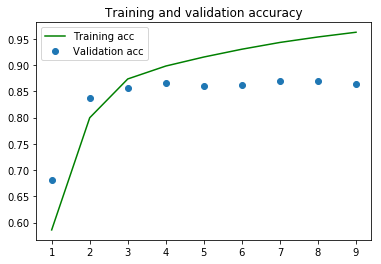

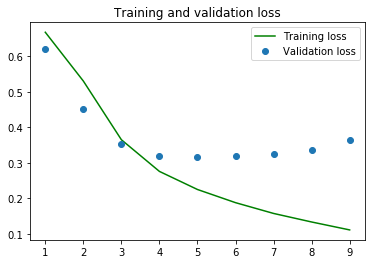

In [23]:
plot(fchist)

<a id='4'></a>
# 4. Build and Train LSTM model

In [24]:
# Lstm model

def lstm():
    model = Sequential()
    
    model.add(Embedding(input_dim=MAX_WORDS, output_dim=EMB_DIM, input_length=MAX_SEQ_LENGTH))
    
    model.add(Bidirectional(LSTM(16, return_sequences=True, recurrent_dropout=0.1, dropout=0.1)))
    
    model.add(Bidirectional(LSTM(32, recurrent_dropout=0.1, dropout=0.1)))
    
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(optimizer = 'rmsprop',
                  loss = 'binary_crossentropy',
                  metrics = ['acc'])
    
    return model

lsmod = lstm()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [25]:
# Train the model
lshist = lsmod.fit(x_train, y_train,
         epochs = EPOCHS,
         batch_size = BATCH_SIZE,
         validation_data = (x_val, y_val))

Train on 24000 samples, validate on 2709 samples
Epoch 1/9
24000/24000 [==============================] - 26s 1ms/step - loss: 0.6646 - acc: 0.5925 - val_loss: 0.5578 - val_acc: 0.7578
Epoch 2/9
24000/24000 [==============================] - 22s 897us/step - loss: 0.4451 - acc: 0.8107 - val_loss: 0.3756 - val_acc: 0.8365
Epoch 3/9
24000/24000 [==============================] - 22s 914us/step - loss: 0.3240 - acc: 0.8705 - val_loss: 0.3450 - val_acc: 0.8520
Epoch 4/9
24000/24000 [==============================] - 22s 926us/step - loss: 0.2647 - acc: 0.8970 - val_loss: 0.3358 - val_acc: 0.8557
Epoch 5/9
24000/24000 [==============================] - 22s 908us/step - loss: 0.2167 - acc: 0.9185 - val_loss: 0.3366 - val_acc: 0.8605
Epoch 6/9
24000/24000 [==============================] - 22s 903us/step - loss: 0.1856 - acc: 0.9311 - val_loss: 0.3510 - val_acc: 0.8649
Epoch 7/9
24000/24000 [==============================] - 22s 913us/step - loss: 0.1567 - acc: 0.9442 - val_loss: 0.3523 - val

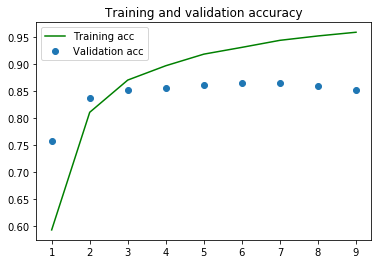

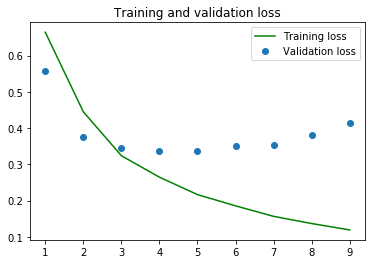

In [26]:
plot(lshist)

<a id='5'></a>
# 5. Build and Train Conv1D model

In [27]:
# Using CONV 1D

def conv1d():
    
    model = Sequential()
    
    model.add(Embedding(input_dim=MAX_WORDS,output_dim=EMB_DIM, input_length=MAX_SEQ_LENGTH))
    
    model.add(Conv1D(filters=32, kernel_size=7, activation='relu'))
    
    model.add(MaxPool1D(pool_size=5))
    
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    
    model.add(Dropout(0.1))
    
    model.add(GlobalMaxPool1D())
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics= ['acc'])
    
    return model

convmod = conv1d()

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 24000 samples, validate on 2709 samples
Epoch 1/20
24000/24000 [==============================] - 2s 82us/step - loss: 0.6802 - acc: 0.5752 - val_loss: 0.6641 - val_acc: 0.6334
Epoch 2/20
24000/24000 [==============================] - 1s 44us/step - loss: 0.6067 - acc: 0.6890 - val_loss: 0.5448 - val_acc: 0.7508
Epoch 3/20
24000/24000 [==============================] - 1s 45us/step - loss: 0.4630 - acc: 0.7983 - val_loss: 0.4353 - val_acc: 0.7951
Epoch 4/20
24000/24000 [==============================] - 1s 49us/step - loss: 0.3595 - acc: 0.8468 - val_loss: 0.3925 - val_acc: 0.8199
Epoch 5/20
24000/24000 [==============================] - 1s 43us/step - loss: 0.3054 - acc: 0.8670 - val_loss: 0.3841 - val_acc: 0.8199
Epoch 6/20
24000/24000 [==============================] - 1s 42us/step - loss: 0.2713 - acc: 0.8819 - val_loss: 0.3884 - val_acc: 0.8162
Epoch 7/20
24000/24000 [===========================

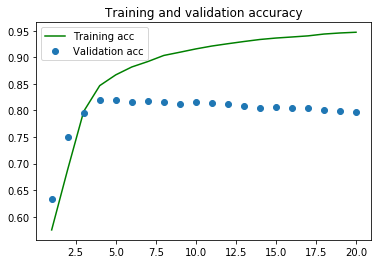

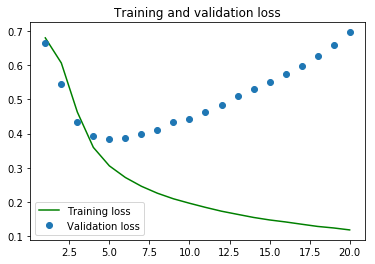

In [28]:
convhist = convmod.fit(x_train, y_train,
                      epochs = 20,
                      batch_size = BATCH_SIZE,
                      validation_data = (x_val, y_val))
plot(convhist)

<a id='6'></a>
# 6. Build and Train Conv1D + GRU model

In [29]:
# Using CONV 1D with GRU

def convgru():
    
    model = Sequential()
    
    model.add(Embedding(input_dim=MAX_WORDS,output_dim=EMB_DIM, input_length=MAX_SEQ_LENGTH))
    
    model.add(Conv1D(filters=32, kernel_size=7, activation='relu'))
    
    model.add(MaxPool1D(pool_size=5))
    
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    
    model.add(GRU(32, dropout=0.1, recurrent_dropout=0.5))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics= ['acc'])
    
    return model

convgrumod = convgru()

Train on 24000 samples, validate on 2709 samples
Epoch 1/6
24000/24000 [==============================] - 3s 130us/step - loss: 0.6794 - acc: 0.5753 - val_loss: 0.6518 - val_acc: 0.6489
Epoch 2/6
24000/24000 [==============================] - 2s 65us/step - loss: 0.5693 - acc: 0.7099 - val_loss: 0.4850 - val_acc: 0.7597
Epoch 3/6
24000/24000 [==============================] - 2s 65us/step - loss: 0.4094 - acc: 0.8088 - val_loss: 0.4082 - val_acc: 0.8058
Epoch 4/6
24000/24000 [==============================] - 2s 65us/step - loss: 0.3281 - acc: 0.8518 - val_loss: 0.3939 - val_acc: 0.8180
Epoch 5/6
24000/24000 [==============================] - 2s 65us/step - loss: 0.2820 - acc: 0.8755 - val_loss: 0.4074 - val_acc: 0.8173
Epoch 6/6
24000/24000 [==============================] - 2s 64us/step - loss: 0.2502 - acc: 0.8897 - val_loss: 0.4120 - val_acc: 0.8176


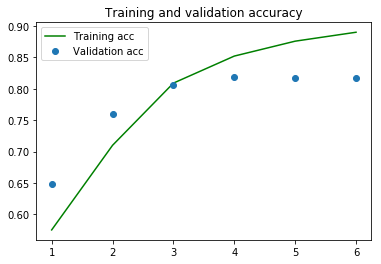

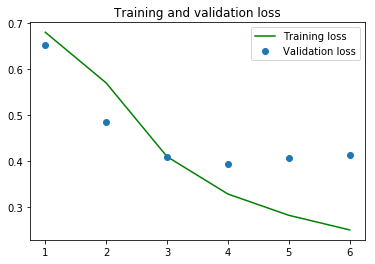

In [30]:
convgruhist = convgrumod.fit(x_train, y_train, 
                           epochs = 6,
                           batch_size=BATCH_SIZE,
                           validation_data = (x_val, y_val))
plot(convgruhist)